C:\Users\user\AppData\Local\Temp\ipykernel_28736\2280008854.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


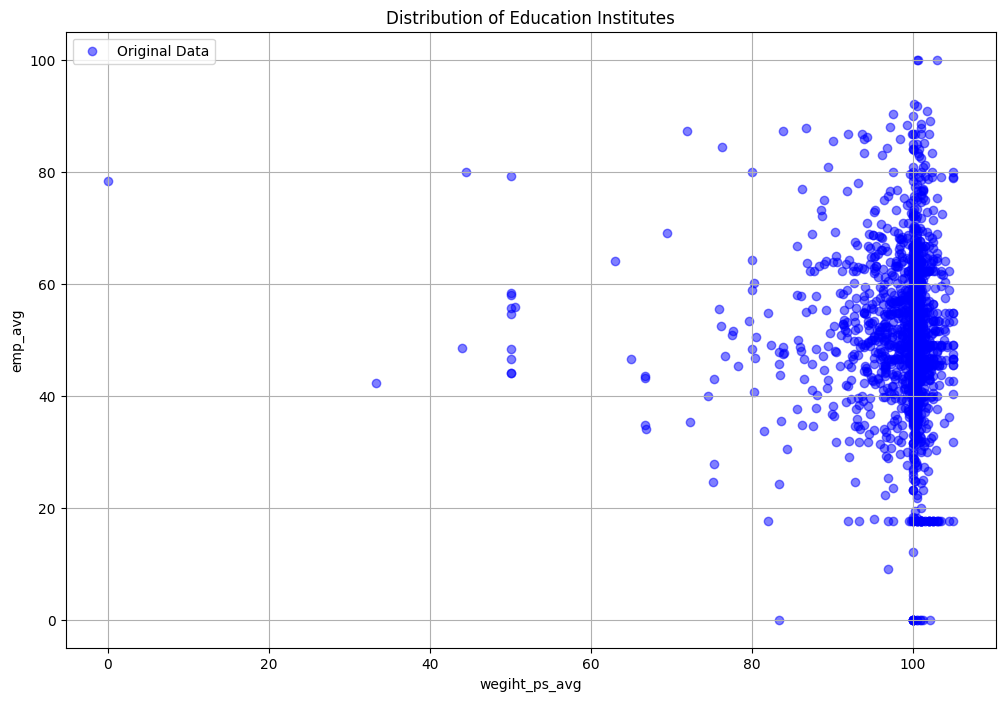

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymysql

# MySQL 데이터베이스 연결 설정
db_config = {

}

# MySQL 데이터베이스에서 데이터 가져오기
def fetch_data_from_db():
    connection = pymysql.connect(**db_config)
    query = "SELECT weight_ps_avg, emp_avg FROM senti_ed3"
    df = pd.read_sql(query, connection)
    connection.close()
    return df

# 데이터 가져오기
df = fetch_data_from_db()

# 분포도 시각화
plt.figure(figsize=(12, 8))

# 원본 데이터 시각화
plt.scatter(df['weight_ps_avg'], df['emp_avg'], color='blue', label='Original Data', alpha=0.5)

# 차트 설정
plt.xlabel('wegiht_ps_avg')
plt.ylabel('emp_avg')
plt.title('Distribution of Education Institutes')
plt.legend()
plt.grid(True)
plt.show()


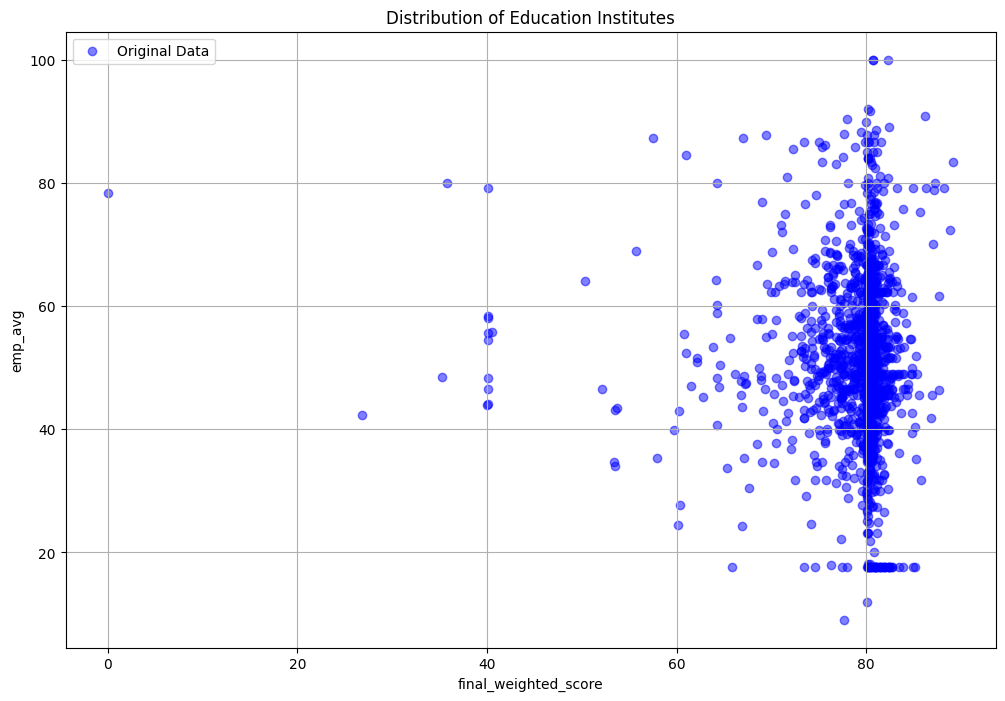

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymysql
import json

# # MySQL 데이터베이스 연결 설정
# db_config = {

# }

# MySQL 데이터베이스에서 데이터 가져오기
with open('./mnt/data/weight_result.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# JSON 데이터를 데이터프레임으로 변환
df = pd.DataFrame(data)




# 분포도 시각화
plt.figure(figsize=(12, 8))

# 원본 데이터 시각화
plt.scatter(df['final_weighted_score'], df['emp'], color='blue', label='Original Data', alpha=0.5)

# 차트 설정
plt.xlabel('final_weighted_score')
plt.ylabel('emp_avg')
plt.title('Distribution of Education Institutes')
plt.legend()
plt.grid(True)
plt.show()


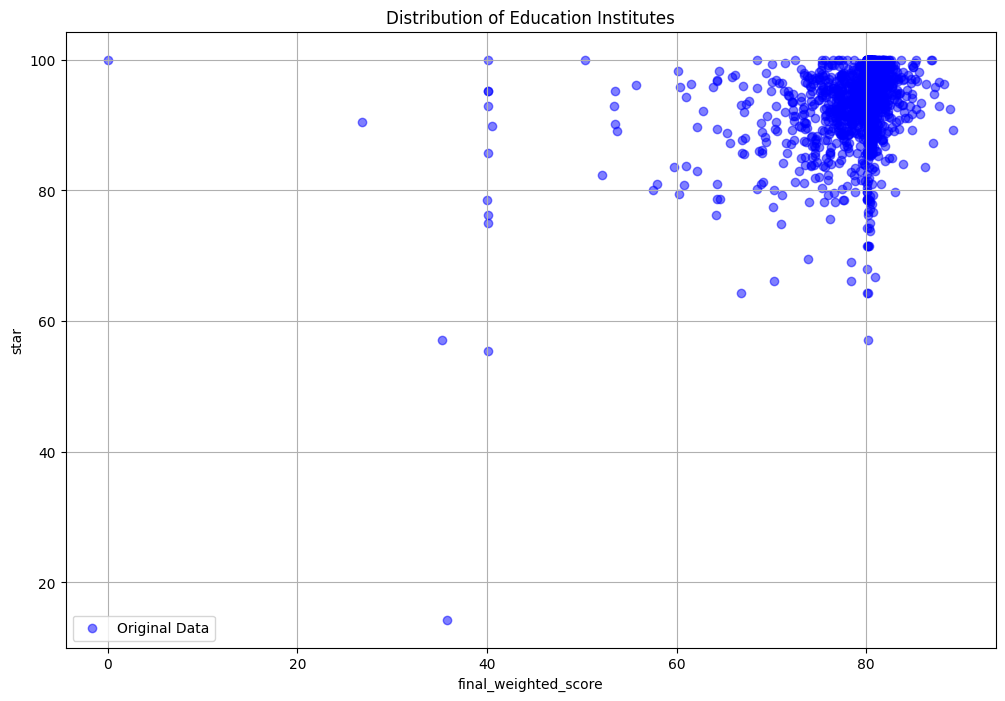

In [31]:

with open('./mnt/data/weight_result.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# JSON 데이터를 데이터프레임으로 변환
df = pd.DataFrame(data)




# 분포도 시각화
plt.figure(figsize=(12, 8))

# 원본 데이터 시각화
plt.scatter(df['final_weighted_score'], df['star'], color='blue', label='Original Data', alpha=0.5)

# 차트 설정
plt.xlabel('final_weighted_score')
plt.ylabel('star')
plt.title('Distribution of Education Institutes')
plt.legend()
plt.grid(True)
plt.show()


cuda
폰트다 뇬석아: NanumGothic


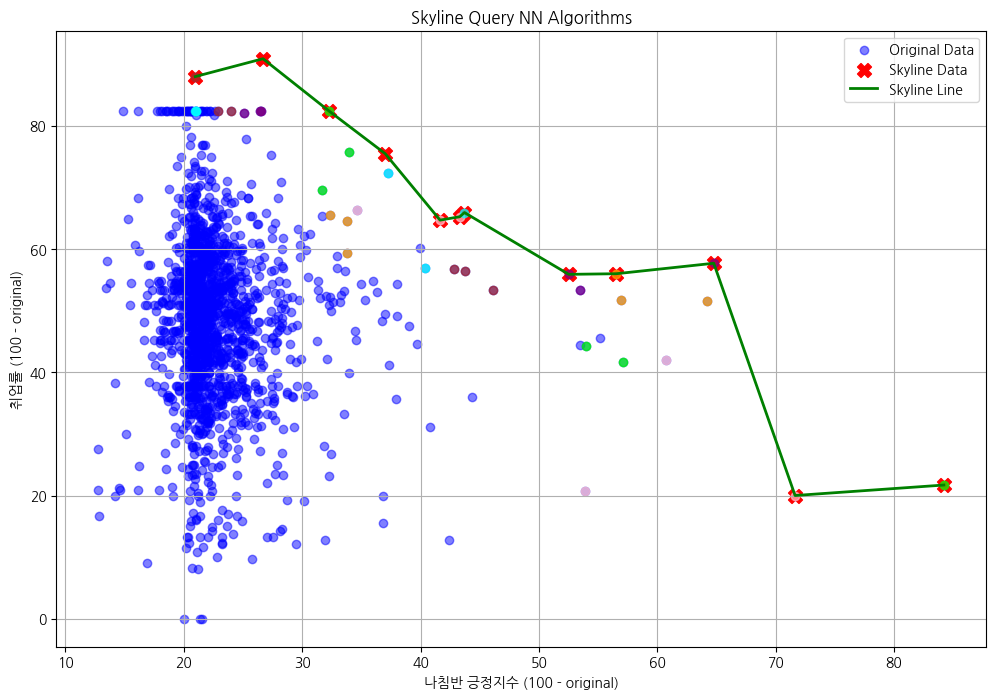

Skyline Points:
    100-final_weighted_score  100-emp            edu_institute  \
0                      35.23    42.30          (사)CH부설제주직업전문학원   
1                      43.46    44.00  (사)도시생명네트워크부설대동요양보호사교육원   
2                      47.48    44.10        (사)충주YWCA요양보호사교육원   
3                      56.29    34.07           (사)한국디지털컨버전스협회   
4                      56.69    34.75      (사)한국수상레저안전연합회 부산지부   
5                      62.99    24.50         (재)BBS미용예술실용전문학교   
6                      58.35    35.30               (재)건설기술교육원   
7                      67.72    17.60        (재)건설기술교육원 서울강남분원   
8                      73.31     9.10               (재)김해직업훈련원   
9                      15.79    78.30              (재)대구직업전문학교   
10                     79.03    12.00              (재)대성직업전문학교   
11                     28.36    80.00      (재)부산인재개발원 부산IT교육센터   

                                          all_reviews  
0   일주일마다 조를 바꿔가면 다른 수강생분들과 어우러져 수업을 들을 수 있어서 좋았어요...  
1   원장님이하 강사님

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from rtree import index
import heapq
import torch
import json
import matplotlib.font_manager as fm
import os

# # MySQL 데이터베이스 연결 설정
# db_config = {

# }

# # SQLAlchemy 엔진 생성
# engine = create_engine(f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

# # MySQL 데이터베이스에서 데이터 가져오기
# def fetch_data_from_db():
   
#     query = "SELECT weight_ps_avg, emp_avg, edu_institute FROM senti_ed3"  # SQL 쿼리
#     df = pd.read_sql(query, engine)  # 쿼리 결과를 데이터프레임으로 변환
#     return df

# # 데이터 가져오기
# df = fetch_data_from_db()

# JSON 파일 읽기
with open('./mnt/data/weight_result.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# JSON 데이터를 데이터프레임으로 변환
df = pd.DataFrame(data)


# 축 변경: 각각 100에서 값을 뺌
df['final_weighted_score'] = 100 - df['final_weighted_score']
df['emp'] = 100 - df['emp']

# PyTorch 텐서로 변환 및 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
ps_tensor = torch.tensor(df['final_weighted_score'].values, dtype=torch.float32).to(device)
s_job_avg_tensor = torch.tensor(df['emp'].values, dtype=torch.float32).to(device)

# R-트리 인덱스 생성
p = index.Property()
p.dimension = 2  # 2차원 데이터
idx = index.Index(properties=p)

# R-트리에 데이터 삽입
for i in range(len(df)):
    idx.insert(i, (ps_tensor[i].item(), s_job_avg_tensor[i].item(), ps_tensor[i].item(), s_job_avg_tensor[i].item()))

# 스카이라인 지배 관계 판단 함수
def is_dominated(point, skyline, threshold):
    """
    주어진 point가 skyline 리스트의 다른 점들에 의해 지배되는지 확인하는 함수
    threshold를 추가하여 지배 조건 조절
    """
    for sk_point in skyline:
        if (sk_point[0] >= point[0] - threshold and sk_point[1] >= point[1] + threshold) and (sk_point[0] > point[0] or sk_point[1] > point[1]):
            return True
    return False

# POA 알고리즘을 사용하여 스카이라인 후보를 가지치기하는 함수
def prune_candidates(candidates, point, threshold):
    """
    현재 point를 기준으로 스카이라인 후보군을 가지치기하는 함수
    threshold를 추가하여 가지치기 조절
    """
    pruned_candidates = []
    for candidate in candidates:
        if not is_dominated(candidate, [point], threshold):
            pruned_candidates.append(candidate)
    return pruned_candidates

# POA와 NN 알고리즘을 사용하여 스카이라인 쿼리 수행
def compute_skyline(ps_tensor, s_job_avg_tensor):
    """
    POA와 NN 알고리즘을 사용하여 스카이라인 쿼리를 수행하는 함수
    """
    skyline = []  # 스카이라인 결과를 저장할 리스트
    heap = []  # 힙 초기화

    # 모든 항목을 힙에 추가
    for i in range(len(ps_tensor)):
        distance = torch.sqrt((ps_tensor[i] - 100)**2 + (s_job_avg_tensor[i] - 100)**2).item()
        heapq.heappush(heap, (distance, i))

    visited_nodes = set()  # 방문한 노드 집합

    while heap:
        min_dist, node_id = heapq.heappop(heap)  # 힙에서 최소 거리 항목 추출
        if node_id in visited_nodes:  # 이미 방문한 노드인 경우 건너뜀
            continue
        visited_nodes.add(node_id)  # 방문한 노드로 추가

        point = (ps_tensor[node_id].item(), s_job_avg_tensor[node_id].item())  # 현재 포인트
        if not is_dominated(point, skyline, threshold=3):  # 지배되지 않는 경우
            skyline.append(point)  # 스카이라인에 추가
            candidates = []  # 후보군 초기화
            for i in range(len(ps_tensor)):  # 각 항목에 대해
                neighbor_point = (ps_tensor[i].item(), s_job_avg_tensor[i].item())
                if not is_dominated(neighbor_point, skyline, threshold=1):  # 이웃 점이 지배되지 않는 경우
                    candidates.append(neighbor_point)  # 후보군에 추가

            # POA 알고리즘을 사용하여 후보군 가지치기
            pruned_candidates = prune_candidates(candidates, point, threshold=3)
            for candidate in pruned_candidates:
                candidate_indices = torch.nonzero((ps_tensor == candidate[0]) & (s_job_avg_tensor == candidate[1]), as_tuple=True)[0]
                for candidate_index in candidate_indices:
                    distance = torch.sqrt((ps_tensor[candidate_index] - 100)**2 + (s_job_avg_tensor[candidate_index] - 100)**2).item()
                    heapq.heappush(heap, (distance, candidate_index.item()))

    return skyline

# 스카이라인 계산
skyline_points = compute_skyline(ps_tensor, s_job_avg_tensor)

# 스카이라인 결과를 데이터프레임으로 변환
skyline_df = pd.DataFrame(skyline_points, columns=['final_weighted_score', 'emp'])

# 원래 값으로 변환
skyline_df['100-final_weighted_score'] = (100 - skyline_df['final_weighted_score']).round(2)
skyline_df['100-emp'] = (100 - skyline_df['emp']).round(2)

# edu_institute 열 추가
skyline_df['edu_institute'] = df['edu_institute'].iloc[skyline_df.index]
skyline_df['all_reviews'] = df['all_reviews'].iloc[skyline_df.index]
# 이웃을 찾기 위한 인덱스
used_indices = set(skyline_df.index)

# 각 스카이라인 포인트에 대해 최근접 이웃 3개 찾기
nearest_neighbors = []
for idx, point in enumerate(skyline_points):
    point_tensor = torch.tensor(point, dtype=torch.float32).to(device)
    distances = torch.sqrt((ps_tensor - point_tensor[0])**2 + (s_job_avg_tensor - point_tensor[1])**2)
    nearest_neighbor_indices = torch.topk(distances, len(df), largest=False).indices[1:]  # 첫 번째는 자기 자신이므로 제외

    # 스카이라인 포인트를 이웃에서 제외하고 상위 3개를 선택, 이미 사용된 인덱스는 제외
    filtered_neighbors = df.iloc[nearest_neighbor_indices.cpu().numpy()]
    filtered_neighbors = filtered_neighbors[~filtered_neighbors.index.isin(used_indices)].head(3)
    used_indices.update(filtered_neighbors.index)
    filtered_neighbors['skyline_index'] = idx  # 스카이라인 포인트의 인덱스를 추가
    nearest_neighbors.append(filtered_neighbors)


# 폰트 파일 경로 설정
font_location = os.path.abspath('C:/font/nanum-all/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf')

            # 폰트를 직접 로드하여 추가# 폰트 프로퍼티 설정
font_prop = fm.FontProperties(fname=font_location)

# 폰트 이름 얻기
font_name = font_prop.get_name()
print(f"폰트다 뇬석아: {font_name}")  # 폰트 이름 출력하여 확인
fm.fontManager.addfont(font_location)

# matplotlib에 폰트 설정
plt.rcParams['font.family'] = font_name


# 원본 데이터와 스카이라인 데이터 시각화
plt.figure(figsize=(12, 8))

# 원본 데이터 시각화
plt.scatter(df['final_weighted_score'], df['emp'], color='blue', label='Original Data', alpha=0.5)

# 스카이라인 데이터 시각화
plt.scatter(skyline_df['final_weighted_score'], skyline_df['emp'], color='red', label='Skyline Data', marker='X', s=100)

# 스카이라인 포인트를 직선으로 연결
if len(skyline_df) > 1:
    sorted_skyline_df = skyline_df.sort_values(by=['final_weighted_score'])
    plt.plot(sorted_skyline_df['final_weighted_score'], sorted_skyline_df['emp'], color='green', linestyle='-', linewidth=2, label='Skyline Line')

# 각 스카이라인 포인트에 대한 최근접 이웃 3개 시각화
colors = ['orange', 'purple', 'brown', 'pink', 'cyan', 'lime']
for idx, neighbors in enumerate(nearest_neighbors):
    plt.scatter(neighbors['final_weighted_score'], neighbors['emp'], color=colors[idx % len(colors)], alpha=0.7)




# 차트 설정
plt.xlabel('나침반 긍정지수 (100 - original)')
plt.ylabel('취업률 (100 - original)')
plt.title('Skyline Query NN Algorithms')
plt.legend()
plt.grid(True)
plt.show()

# 스카이라인 결과 및 근접 이웃 데이터프레임으로 결합
all_neighbors = pd.concat(nearest_neighbors).reset_index(drop=True)
all_neighbors['100-final_weighted_score'] = 100 - all_neighbors['final_weighted_score']
all_neighbors['100-emp'] = 100 - all_neighbors['emp']

# 스카이라인 포인트와 근접 이웃 정렬
all_neighbors_sorted = all_neighbors.sort_values(by='skyline_index').reset_index(drop=True)

# 스카이라인 포인트와 근접 이웃 출력
print("Skyline Points:")
print(skyline_df[['100-final_weighted_score', '100-emp', 'edu_institute','all_reviews']])

print("\nNearest Neighbors:")
print(all_neighbors_sorted[['final_weighted_score', 'emp', 'edu_institute','all_reviews', 'skyline_index']])

# JSON 변환
skyline_json = skyline_df[['100-final_weighted_score', '100-emp', 'edu_institute','all_reviews']].to_json(orient="records", force_ascii=False)
neighbors_json = all_neighbors_sorted[['final_weighted_score', 'emp', 'edu_institute', 'all_reviews','skyline_index']].to_json(orient="records", force_ascii=False)

# JSON 결과 출력
print("\nSkyline JSON:")
print(skyline_json)

print("\nNeighbors JSON:")
print(neighbors_json)

# JSON 파일로 저장
with open('skyline.json', 'w', encoding='utf-8') as f:
    f.write(skyline_json)

with open('neighbors.json', 'w', encoding='utf-8') as f:
    f.write(neighbors_json)

print("\nJSON 파일 저장 완료: skyline.json, neighbors.json")

In [34]:
import json
import pandas as pd

# JSON 파일 경로 설정
skyline_json_path = './skylinedata/skyline.json'
neighbors_json_path = './skylinedata/neighbors.json'
output_json_path = './skylinedata/skyline_result2.json'
output_skyline_csv_path = './skylinedata/skyline.csv'
output_neighbors_csv_path = './skylinedata/neighbors.csv'

# JSON 파일 로드
with open(skyline_json_path, 'r', encoding='utf-8') as file:
    skyline_data = json.load(file)

with open(neighbors_json_path, 'r', encoding='utf-8') as file:
    neighbors_data = json.load(file)

# 데이터 합치기
combined_data = {
    "skyline": skyline_data,
    "neighbors": neighbors_data
}

# 합친 데이터를 JSON 파일로 저장
with open(output_json_path, 'w', encoding='utf-8') as file:
    json.dump(combined_data, file, ensure_ascii=False, indent=4)

print(f"Combined data saved to {output_json_path}")

# 데이터프레임으로 변환
skyline_df = pd.DataFrame(skyline_data)
neighbors_df = pd.DataFrame(neighbors_data)

# CSV 파일로 각각 저장
skyline_df.to_csv(output_skyline_csv_path, index=False, encoding='utf-8')
neighbors_df.to_csv(output_neighbors_csv_path, index=False, encoding='utf-8')

print(f"Skyline data saved to {output_skyline_csv_path}")
print(f"Neighbors data saved to {output_neighbors_csv_path}")


Combined data saved to ./skylinedata/skyline_result2.json
Skyline data saved to ./skylinedata/skyline.csv
Neighbors data saved to ./skylinedata/neighbors.csv


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors


with open('./mnt/data/weight_result.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# JSON 데이터를 데이터프레임으로 변환
df = pd.DataFrame(data)
df

,edu_institute,average_result,positive_count,star,emp,final_weighted_score,all_reviews
0,(사)CH부설제주직업전문학원,0.74,6.40,83.50,39.90,60.03,일주일마다 조를 바꿔가면 다른 수강생분들과 어우러져 수업을 들을 수 있어서 좋았어요...
1,(사)도시생명네트워크부설대동요양보호사교육원,1.00,14.00,97.60,54.70,79.61,원장님이하 강사님들께서 친절하게 잘 가르켜 주셔서 자격증을 취득하였고 다른분들에게 ...
2,(사)충주YWCA요양보호사교육원,0.91,20.00,95.80,55.70,74.01,여러가지 몰랐던것을 많이배웠다 수강을 통해 치매에관하여 알게되었고 일반생활에서 많은...
3,(사)한국디지털컨버전스협회,0.92,1.00,78.25,39.40,70.16,일러스트 어려운데 열심희 공부헤야겟네여 수업내용이 매우 유용하게 잘 구성되었습니다 ...
4,(사)한국수상레저안전연합회 부산지부,1.00,1.00,92.90,44.00,77.72,훈련과정이 전혀 지루하지않고 재밌고 매우 유익하였다
...,...,...,...,...,...,...,...
1569,흙바라기도예공방학원,1.00,9.67,98.03,31.70,79.35,도예 물레에 대해 적합한 지식과 실기를 전반적으로 익히는 데 도움되었습니다 자기계발...
1570,희망가득요양보호사교육원,1.00,30.67,99.30,30.30,81.25,직장다니면서 주말반 요양보호사반을 들었는데요 학원도 좋고 실습도 같은 건물에서 해서...
1571,희망요양보호사교육원,0.90,24.00,88.10,24.65,72.66,간호학 강의는 좋았습니다 다만 그외 강의에서 혐오발언이나 자신 자식자랑 등이 듣기 ...
1572,희망직업전문학교,1.00,10.50,94.55,64.20,78.78,선생님과 학원장님이 친절히 잘설명해주시고 알려주신 덕분에 어느정도는 도움이 되었던거...
